Collab link: 
https://colab.research.google.com/notebooks/mlcc/first_steps_with_tensor_flow.ipynb

Importing the necessary libraries first:

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# printing TF and python versions:
print(tf.__version__)
# print(python --version)  # doesn't work
from platform import python_version
print(python_version())

1.15.0
3.6.9


Loading the database:

In [0]:
chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')
chdf.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0
5,-114.6,33.6,29.0,1387.0,236.0,671.0,239.0,3.3,74000.0
6,-114.6,33.6,25.0,2907.0,680.0,1841.0,633.0,2.7,82400.0
7,-114.6,34.8,41.0,812.0,168.0,375.0,158.0,1.7,48500.0
8,-114.6,33.6,34.0,4789.0,1175.0,3134.0,1056.0,2.2,58400.0
9,-114.6,34.8,46.0,1497.0,309.0,787.0,271.0,2.2,48100.0


Randomising the order of the data:

In [0]:
chdf = chdf.reindex(np.random.permutation(chdf.index))  # order of the df randomised
# scaling features:
chdf['median_house_value'] /= 1000.0
#chdf['median_house_value'] -= chdf['median_house_value'].mean()
#chdf['median_house_value'] /= chdf['median_house_value'].std()
chdf.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
4388,-118.0,33.8,26.0,2989.0,479.0,1596.0,475.0,5.7,231.2
8453,-118.5,34.2,32.0,2108.0,309.0,769.0,274.0,8.7,500.0
3997,-118.0,34.1,33.0,1328.0,348.0,903.0,329.0,3.1,136.0
11195,-121.0,37.6,27.0,958.0,184.0,580.0,177.0,2.2,82.8
1054,-117.1,33.7,18.0,4799.0,1035.0,1966.0,944.0,2.1,71.3
1085,-117.1,32.8,20.0,1667.0,469.0,1292.0,445.0,2.1,101.1
6179,-118.2,34.1,37.0,1644.0,395.0,959.0,383.0,3.4,257.7
16374,-122.5,37.9,37.0,2524.0,398.0,999.0,417.0,8.0,500.0
6948,-118.3,34.0,38.0,1864.0,515.0,1768.0,439.0,1.9,190.6
10368,-120.2,39.1,21.0,2484.0,460.0,309.0,144.0,4.0,127.8


Describing the data:

In [0]:
chdf.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


Build the First Model:

Step 1: Define features and their 'column':

In [0]:
# Define the input feature:
my_feature = chdf[['total_rooms']]  ## converts this pd column into an array
#my_feature = chdf['total_rooms']   ## it keeps it as a pd series!!!
print(my_feature)

# Configure a numeric feature column for the feature.
my_feature_columns = [tf.feature_column.numeric_column("total_rooms")]
print(my_feature_columns)

# Feature scaling:
my_feature -= my_feature.mean()
my_feature /= my_feature.std()
print(my_feature)

       total_rooms
4388        2989.0
8453        2108.0
3997        1328.0
11195        958.0
1054        4799.0
...            ...
8968        6106.0
3896        2781.0
7123        1722.0
8705        4891.0
3918        2686.0

[17000 rows x 1 columns]
[NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]
       total_rooms
4388           0.2
8453          -0.2
3997          -0.6
11195         -0.8
1054           1.0
...            ...
8968           1.6
3896           0.1
7123          -0.4
8705           1.0
3918           0.0

[17000 rows x 1 columns]


Step 2: Define the Target

In [0]:
# Define the label:
targets = chdf['median_house_value']

Step 3: Configure the LinearRegressor

In [0]:
# Use gradient descent as the optimizer for training the model.
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(feature_columns = my_feature_columns, optimizer = my_optimizer)


Step 4: Input Function

Dataset link: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # batch_size: number of training examples per batch
    # shuffle: randomise the examples
    # num_epochs: number of batches to take. None means infinite.
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}

    # Construct a TF dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets))  # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified:
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)

    # Return the next batch of data:
    features, labels = ds.make_one_shot_iterator().get_next()  
    return features, labels

In [0]:
# # # Convert pandas data into a dict of np arrays.
# # features = {key:np.array(value) for key,value in dict(my_feature).items()}

# # # Construct a TF dataset, and configure batching/repeating.
# # ds = tf.data.Dataset.from_tensor_slices((features,targets))  # warning: 2GB limit
# # ds = ds.batch(1)#.repeat(None)

# ds = Dataset.from_tensor_slices([1, 2, 3])
# for el in ds: 
#   print(el.as_numpy_iterator())



Step 5: Train the Model

In [0]:
# Train is to get the linear regression weights via gradient optimisation
_ = linear_regressor.train( input_fn = lambda : my_input_fn(my_feature, targets), steps=100 )  # .train gets the weights


Step 6: Evaluate the Model

In [0]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't need to repeat or shuffle the data here.
prediction_input_fn = lambda : my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear regressor to make predictions.
predictions = linear_regressor.predict( input_fn = prediction_input_fn )  # .predicts evaluates the function with the trained weights
# for item in predictions:
  # print(item['predictions'])

# Format predictions as a NumPy array, so we can calculate error metrics:
predictions = np.array( [ item['predictions'][0] for item in predictions ] )   # the [0] converts it to a 1D array (vector) of m values. without the [0] it would create a 2D array (matrix) of mx1
print(predictions.shape)
for i in range(0,10,1):
  print(predictions[i], targets[i])

# Print Mean Squared Error and Root Mean Squared Error:
mean_squared_error = metrics.mean_squared_error(predictions, targets)  # variance
root_mean_squared_error = math.sqrt(mean_squared_error)  # std deviation

print('Mean Squared Error (on training data): %0.3f' %(mean_squared_error))
print('Root Mean Squared Error (on training data): %0.3f' %(root_mean_squared_error))

(17000,)
4.3387965e-05 66.9
4.622885e-05 80.1
4.874405e-05 85.7
4.9937156e-05 73.4
3.7551414e-05 65.5
4.7650905e-05 74.0
4.7725072e-05 82.4
4.4887413e-05 48.5
4.7015656e-05 58.4
4.5016397e-05 48.1
Mean Squared Error (on training data): 56425.092
Root Mean Squared Error (on training data): 237.540


Comparing the RMSE to the scale of the original targets:

In [0]:
min_house_value = chdf['median_house_value'].min()
max_house_value = chdf['median_house_value'].max()
min_max_diff = max_house_value - min_house_value

print('Minimum house value: %0.3f' %(min_house_value))
print('Maximum house value: %0.3f' %(max_house_value))
print('Difference between Min and Max: %0.3f' %(min_max_diff))
print('Root Mean Squared Error (on training data): %0.3f' %(root_mean_squared_error))

Minimum house value: 14.999
Maximum house value: 500.001
Difference between Min and Max: 485.002
Root Mean Squared Error (on training data): 237.540


Comparing predictions vs actual targets:

In [0]:
calibration_data = pd.DataFrame()  # this initialises a dataframe
calibration_data['predictions'] = pd.Series(predictions)
calibration_data['targets'] = pd.Series(targets)

for i in range(0,10,1):
  print(predictions[i])
print(calibration_data.head())
calibration_data.describe()

4.3387965e-05
4.622885e-05
4.874405e-05
4.9937156e-05
3.7551414e-05
4.7650905e-05
4.7725072e-05
4.4887413e-05
4.7015656e-05
4.5016397e-05
   predictions  targets
0          0.0     66.9
1          0.0     80.1
2          0.0     85.7
3          0.0     73.4
4          0.0     65.5


,predictions,targets
count,17000.0,17000.0
mean,0.0,207.3
std,0.0,116.0
min,-0.0,15.0
25%,0.0,119.4
50%,0.0,180.4
75%,0.0,265.0
max,0.0,500.0


Visualising the results:

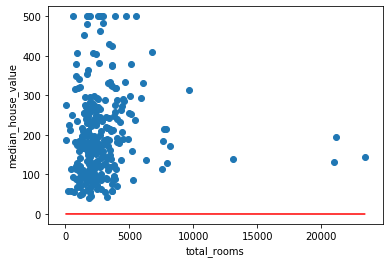

In [0]:
# Taking 300 samples randomly
sample = chdf.sample(n=300)

# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training:
weights = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weights * x_0 + bias
y_1 = weights * x_1 + bias

# Plot our regression line from (x0, y0) to (x1, y1):
plt.plot([x_0, x_1], [y_0, y_1], c='r', label='prediction')

# Scattering the sample data:
plt.scatter(sample['total_rooms'], sample['median_house_value'], label='sample data')

plt.xlabel('total_rooms')
plt.ylabel('median_house_value')
plt.show()



Putting the trainer in a Function and improving the model:
# Linear Regression with one feature:


Training model...
RMSE (on training data):
  period 00 : 166.32
  period 01 : 166.32
  period 02 : 169.35
  period 03 : 166.33
  period 04 : 166.33
  period 05 : 166.33
  period 06 : 166.33
  period 07 : 169.33
  period 08 : 166.33
  period 09 : 166.33
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,132.8,207.3
std,109.5,116.0
min,0.1,15.0
25%,73.4,119.4
50%,106.8,180.4
75%,158.2,265.0
max,1904.9,500.0


Final RMSE (on training data): 166.33


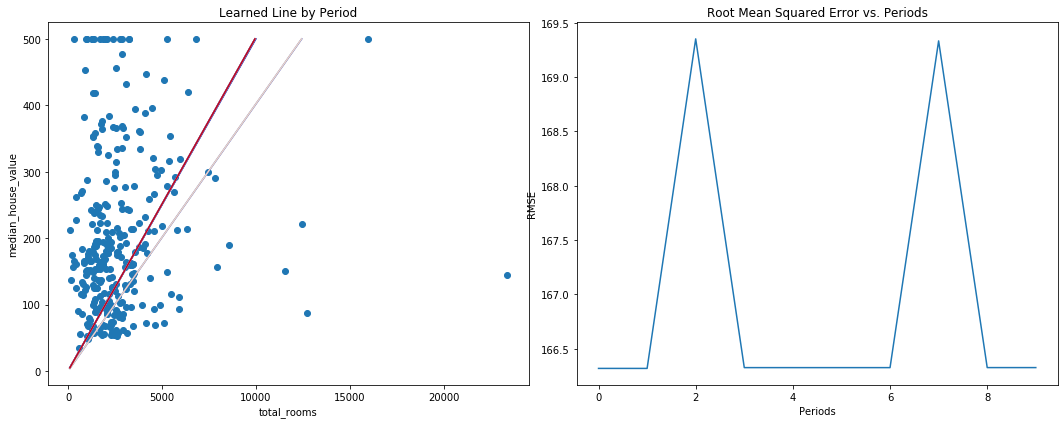

In [0]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = chdf[[my_feature]]
  my_label = "median_house_value"
  targets = chdf[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda : my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda : my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = chdf.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))

    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents, sample[my_feature].max()), sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)


# Call the model function:
train_model(learning_rate=0.001, steps=100, batch_size=1000)



Trying a different feature:


Training model...
RMSE (on training data):
  period 00 : 188.58
  period 01 : 176.00
  period 02 : 176.00
  period 03 : 176.00
  period 04 : 176.00
  period 05 : 176.00
  period 06 : 176.00
  period 07 : 176.00
  period 08 : 176.39
  period 09 : 176.00
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,128.7,207.3
std,103.3,116.0
min,0.3,15.0
25%,71.1,119.4
50%,105.1,180.4
75%,154.9,265.0
max,3212.0,500.0


Final RMSE (on training data): 176.00


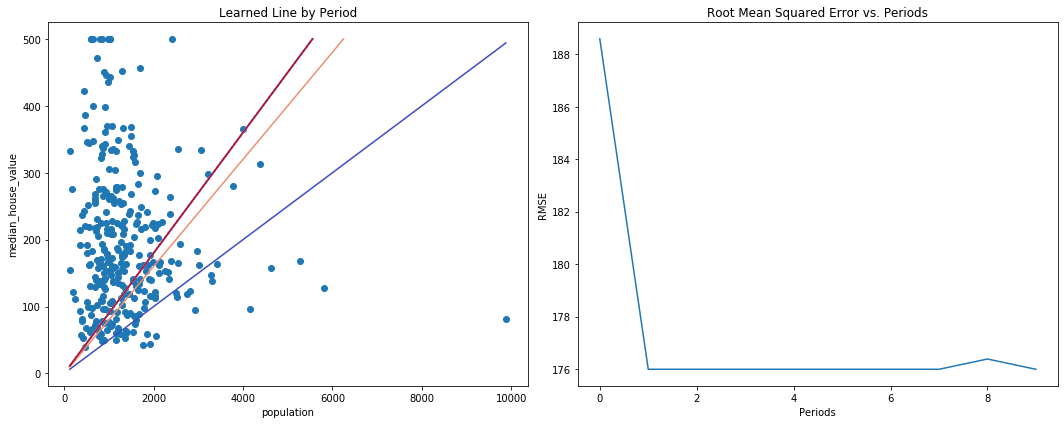

In [0]:
train_model(learning_rate=0.001, steps=100, batch_size=1000, input_feature='population')

Appendix:
Small test to understand tf.data.Dataset

Dataset link: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator

In [0]:
## Understanding Dataset in TF:

from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.python.data import Dataset

# Creating a dataset for TF from a dataset (an array in this case):
tfds = tf.data.Dataset.from_tensor_slices([0,1,2,3,4,5,6,7,8,9])
# splitting it into batches. repeating the batches for num_epochs=3
tfds = tfds.batch(3).repeat(3)

# shuffling the batches. but the content in the batches do not change!
tfds = tfds.shuffle(buffer_size=10000)

# printing the content of the batches
print(list(tfds.as_numpy_iterator()))  # this is for TF2!!!

print('')
for element in tfds :
  print(element)

print('')
for element in tfds.as_numpy_iterator() :
  print(element)

print('')
for element in list(tfds.as_numpy_iterator()) :
  print(element)


[array([3, 4, 5], dtype=int32), array([9], dtype=int32), array([3, 4, 5], dtype=int32), array([9], dtype=int32), array([9], dtype=int32), array([6, 7, 8], dtype=int32), array([6, 7, 8], dtype=int32), array([3, 4, 5], dtype=int32), array([0, 1, 2], dtype=int32), array([0, 1, 2], dtype=int32), array([0, 1, 2], dtype=int32), array([6, 7, 8], dtype=int32)]

tf.Tensor([3 4 5], shape=(3,), dtype=int32)
tf.Tensor([6 7 8], shape=(3,), dtype=int32)
tf.Tensor([9], shape=(1,), dtype=int32)
tf.Tensor([3 4 5], shape=(3,), dtype=int32)
tf.Tensor([6 7 8], shape=(3,), dtype=int32)
tf.Tensor([9], shape=(1,), dtype=int32)
tf.Tensor([0 1 2], shape=(3,), dtype=int32)
tf.Tensor([0 1 2], shape=(3,), dtype=int32)
tf.Tensor([0 1 2], shape=(3,), dtype=int32)
tf.Tensor([3 4 5], shape=(3,), dtype=int32)
tf.Tensor([6 7 8], shape=(3,), dtype=int32)
tf.Tensor([9], shape=(1,), dtype=int32)

[3 4 5]
[9]
[9]
[0 1 2]
[6 7 8]
[6 7 8]
[9]
[6 7 8]
[0 1 2]
[3 4 5]
[3 4 5]
[0 1 2]

[9]
[9]
[0 1 2]
[3 4 5]
[0 1 2]
[0 1 2]
[3